Ethan Biegeleisen

MATG 691 Project

December 7, 2021

In [1]:
# Imports from Course 4, Week 1, Assignment 2

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from cnnutils import * # Code from original assignment said cnn_utils instead of cnnutils

%matplotlib inline

In [2]:
# Imports from Course 4, Week 2, Assignment 1

import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

%matplotlib inline

### Preparing the 64 x 64 x 3 Images

In [3]:
# Importing every image from the positive dataset and turning each image into an array

import glob

Images_Positive64 = []
X_Positive64 = []
for filename in glob.glob('Documents/Manhattan College/Fall 2021/MATG 691/MATG 691 Project/Aria Data/COVID-19_Lung_CT_Scans/COVID-19 (944 Images)/*.png'):
    Image_Positive64 = image.load_img(filename, target_size = (64, 64))
    x_Positive64 = image.img_to_array(Image_Positive64)
    Images_Positive64.append(Image_Positive64)
    X_Positive64.append(x_Positive64)

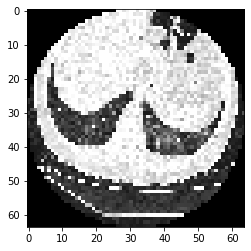

In [4]:
imshow(Images_Positive64[851])

In [5]:
# Importing every image from the negative dataset and turning each image into an array

Images_Negative64 = []
X_Negative64 = []
for filename in glob.glob('Documents/Manhattan College/Fall 2021/MATG 691/MATG 691 Project/Aria Data/COVID-19_Lung_CT_Scans/Non-COVID-19/*.png'):
    Image_Negative64 = image.load_img(filename, target_size = (64, 64))
    x_Negative64 = image.img_to_array(Image_Negative64)
    Images_Negative64.append(Image_Negative64)
    X_Negative64.append(x_Negative64)

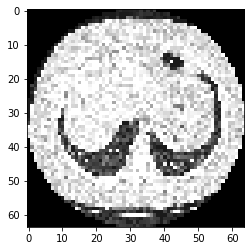

In [6]:
imshow(Images_Negative64[821])

In [7]:
# Standardizing the image arrays

for i in range(len(X_Positive64)):
    X_Positive64[i] = X_Positive64[i]/255.0
    
for i in range(len(X_Negative64)):
    X_Negative64[i] = X_Negative64[i]/255.0

In [8]:
# Creating labels for the image arrays
# These labels can be used for any image size

Y_Positive = np.ones(len(X_Positive64))
Y_Negative = np.zeros(len(X_Negative64))

In [9]:
# Creating X and Y by stacking the positive and negative image arrays

X64 = np.vstack((X_Positive64, X_Negative64))
Y64 = np.hstack((Y_Positive, Y_Negative))

In [10]:
# Splitting X and Y into train and test sets

from sklearn.model_selection import train_test_split
X_Train64, X_Test64, Y_Train64, Y_Test64 = train_test_split(X64, Y64, test_size = 0.1, random_state = 42)

### Creating the Convolutional Block Functions

In [11]:
# Creating the convolutional block function for a standard network (no skip connection)

def convolutional_block_standard(X, f, filters, s = 2, training = True, initializer = glorot_uniform):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    # For the first component, a convolutional layer is applied to the input with filter size F1 x F1, a stride of s, and padding applied to the input 
    # This is followed by batch normalization and a ReLU activation
    
    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    # For the second component, a convolutional layer is applied to the input with filter size F2 x F2, a stride of 1, and no padding applied to the input
    # This is followed by batch normalization and a ReLU activation
    
    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)

    # For the third component, a convolutional layer is applied to the input with filter size F3 x F3, a stride of 1, and padding applied to the input
    # This is followed by batch normalization  
    
    # Final step: Pass the main path through a RELU activation
    X = Activation('relu')(X)
    
    # For the final step, the input is passed through a ReLU activation
    
    return X

In [12]:
# Creating the convolutional block function for a residual network (skip connection)

def convolutional_block_skip(X, f, filters, s = 2, training = True, initializer = glorot_uniform):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    # For the first component, a convolutional layer is applied to the input with filter size F1 x F1, a stride of s, and padding applied to the input 
    # This is followed by batch normalization and a ReLU activation
    
    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    # For the second component, a convolutional layer is applied to the input with filter size F2 x F2, a stride of 1, and no padding applied to the input
    # This is followed by batch normalization and a ReLU activation
    
    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    # For the third component, a convolutional layer is applied to the input with filter size F3 x F3, a stride of 1, and padding applied to the input
    # This is followed by batch normalization    
    
    ##### SHORTCUT PATH #####
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)

    # For shortcut path, a convolutional layer is applied to the initial input with filter size F3 x F3, a stride of s, and padding applied to the input 
    # This is followed by batch normalization
    
    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    # For the final step, the input that went through the third component is added with the input that went through the shorcut path
    # This is followed by a ReLU activation
    
    return X

### Using a Standard Convolutional Neural Network with 64 x 64 x 3 Images

In [13]:
# Creating the model

def StandardModel64(input_shape = (64, 64, 3), classes = 1):
    """
    Stage-wise implementation of the architecture of the standard convolutional neural network for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK (no skip connection) -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Three layers of zero padding are placed around the input
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # For Stage 1, a convolutional layer is applied to the input with filter size 64 x 64 and a stride of 2
    # This is followed by batch normalization and a ReLU activation
    # Lastly, a max pooling layer is applied with filter size 3 x 3 and a stride of 2

    # Stage 2
    X = convolutional_block_standard(X, f = 3, filters = [64, 64, 256], s = 1)
    
    # For Stage 2, the standard convolutional block function is applied to the input with filter sizes of 64 x 64, 64 x 64, and 256 x 256

    ## AVGPOOL
    X = AveragePooling2D(pool_size = (2, 2))(X)
    
    # An average pooling filter is applied to the input with a filter size 2 x 2

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # The final section involves flattening the input into a vector
    # The vector is then passed through a dense neural network layer with sigmoid activation
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [14]:
Standard_Model64 = StandardModel64(input_shape = (64, 64, 3), classes = 1)

# Compile the model
Standard_Model64.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
Standard_Model64.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        4160  

In [15]:
# Training the model
Standard_History64 = Standard_Model64.fit(X_Train64, Y_Train64, epochs = 200, batch_size = 8)

Epoch 1/200
213/213 [==============================] - ETA: 2:58 - loss: 0.9525 - accuracy: 0.75 - ETA: 7s - loss: 1.3032 - accuracy: 0.6250 - ETA: 7s - loss: 1.1245 - accuracy: 0.65 - ETA: 7s - loss: 1.0270 - accuracy: 0.67 - ETA: 7s - loss: 0.8971 - accuracy: 0.72 - ETA: 6s - loss: 0.8325 - accuracy: 0.72 - ETA: 6s - loss: 0.7600 - accuracy: 0.75 - ETA: 6s - loss: 0.7449 - accuracy: 0.75 - ETA: 6s - loss: 0.7193 - accuracy: 0.76 - ETA: 6s - loss: 0.6615 - accuracy: 0.78 - ETA: 6s - loss: 0.6650 - accuracy: 0.77 - ETA: 6s - loss: 0.6650 - accuracy: 0.77 - ETA: 6s - loss: 0.6410 - accuracy: 0.78 - ETA: 6s - loss: 0.6472 - accuracy: 0.77 - ETA: 6s - loss: 0.6390 - accuracy: 0.78 - ETA: 6s - loss: 0.6098 - accuracy: 0.78 - ETA: 6s - loss: 0.6102 - accuracy: 0.78 - ETA: 6s - loss: 0.6055 - accuracy: 0.78 - ETA: 6s - loss: 0.5905 - accuracy: 0.78 - ETA: 6s - loss: 0.5715 - accuracy: 0.79 - ETA: 6s - loss: 0.5698 - accuracy: 0.78 - ETA: 6s - loss: 0.5552 - accuracy: 0.79 - ETA: 6s - loss: 0

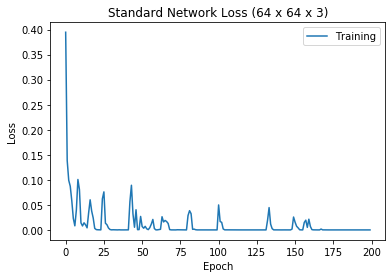

In [16]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History64.history['loss'])
plt.title('Standard Network Loss (64 x 64 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

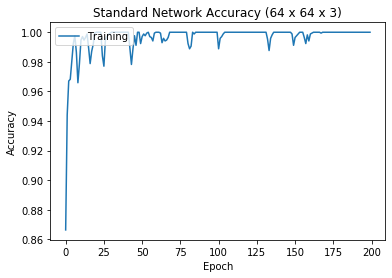

In [17]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History64.history['accuracy'])
plt.title('Standard Network Accuracy (64 x 64 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper left')
plt.show()

In [18]:
# Testing the model
Standard_Test_Loss64, Standard_Test_Accuracy64 = Standard_Model64.evaluate(X_Test64, Y_Test64)

6/6 [==============================] - ETA: 1s - loss: 0.3417 - accuracy: 0.96 - ETA: 0s - loss: 0.1139 - accuracy: 0.98 - ETA: 0s - loss: 0.0804 - accuracy: 0.98 - 0s 36ms/step - loss: 0.0680 - accuracy: 0.9894


In [19]:
print('Test Loss:', Standard_Test_Loss64)
print('Test Accuracy:', Standard_Test_Accuracy64)

Test Loss: 0.06802653521299362
Test Accuracy: 0.9894179701805115


### Using a Residual Network with 64 x 64 x 3 Images

In [20]:
# Creating the model

def ResNet64(input_shape = (64, 64, 3), classes = 1):
    """
    Stage-wise implementation of the architecture of the standard convolutional neural network for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK (skip connection) -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Three layers of zero padding are placed around the input
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # For Stage 1, a convolutional layer is applied to the input with filter size 64 x 64 and a stride of 2
    # This is followed by batch normalization and a ReLU activation
    # Lastly, a max pooling layer is applied with filter size 3 x 3 and a stride of 2


    # Stage 2
    X = convolutional_block_skip(X, f = 3, filters = [64, 64, 256], s = 1)
    
    # For Stage 2, the convolutional block function with a skip connection is applied to the input with filter sizes of 64 x 64, 64 x 64, and 256 x 256
    
    ## AVGPOOL
    X = AveragePooling2D(pool_size = (2, 2))(X)

    # An average pooling filter is applied to the input with a filter size 2 x 2
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # The final section involves flattening the input into a vector
    # The vector is then passed through a dense neural network layer with sigmoid activation
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [21]:
ResNet_Model64 = ResNet64(input_shape = (64, 64, 3), classes = 1)

# Compile the model
ResNet_Model64.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
print(ResNet_Model64.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 32, 32, 64)   256         conv2d_4[0][0]                   
____________________________________________________________________________________________

In [22]:
# Training the model
ResNet_History64 = ResNet_Model64.fit(X_Train64, Y_Train64, epochs = 200, batch_size = 8)

Epoch 1/200
213/213 [==============================] - ETA: 2:21 - loss: 2.0449 - accuracy: 0.12 - ETA: 7s - loss: 1.7246 - accuracy: 0.5833 - ETA: 6s - loss: 1.4334 - accuracy: 0.60 - ETA: 6s - loss: 1.2535 - accuracy: 0.62 - ETA: 6s - loss: 1.0678 - accuracy: 0.68 - ETA: 6s - loss: 0.9392 - accuracy: 0.71 - ETA: 6s - loss: 0.8258 - accuracy: 0.75 - ETA: 6s - loss: 0.7842 - accuracy: 0.75 - ETA: 6s - loss: 0.7094 - accuracy: 0.77 - ETA: 6s - loss: 0.7406 - accuracy: 0.76 - ETA: 6s - loss: 0.7266 - accuracy: 0.76 - ETA: 6s - loss: 0.6924 - accuracy: 0.76 - ETA: 6s - loss: 0.7272 - accuracy: 0.76 - ETA: 6s - loss: 0.6819 - accuracy: 0.78 - ETA: 6s - loss: 0.6511 - accuracy: 0.79 - ETA: 6s - loss: 0.6284 - accuracy: 0.79 - ETA: 6s - loss: 0.6125 - accuracy: 0.79 - ETA: 6s - loss: 0.6222 - accuracy: 0.80 - ETA: 5s - loss: 0.6553 - accuracy: 0.79 - ETA: 5s - loss: 0.6410 - accuracy: 0.79 - ETA: 5s - loss: 0.6223 - accuracy: 0.80 - ETA: 5s - loss: 0.6064 - accuracy: 0.80 - ETA: 5s - loss: 0

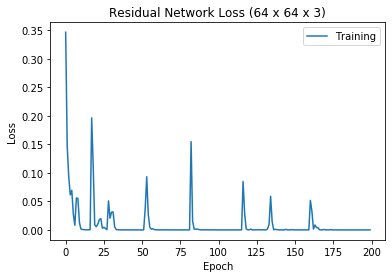

In [23]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(ResNet_History64.history['loss'])
plt.title('Residual Network Loss (64 x 64 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

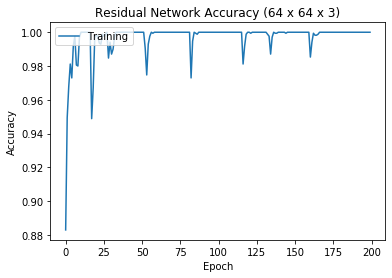

In [24]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(ResNet_History64.history['accuracy'])
plt.title('Residual Network Accuracy (64 x 64 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper left')
plt.show()

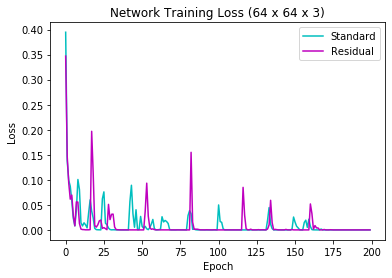

In [25]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History64.history['loss'], color = 'c')
plt.plot(ResNet_History64.history['loss'], color = 'm')
plt.title('Network Training Loss (64 x 64 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Standard', 'Residual'], loc='upper right')
plt.show()

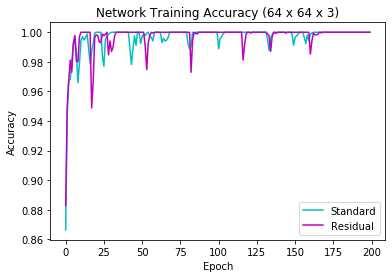

In [26]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History64.history['accuracy'], color = 'c')
plt.plot(ResNet_History64.history['accuracy'], color = 'm')
plt.title('Network Training Accuracy (64 x 64 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Standard', 'Residual'], loc='lower right')
plt.show()

In [27]:
# Testing the model
ResNet_Test_Loss64, ResNet_Test_Accuracy64 = ResNet_Model64.evaluate(X_Test64, Y_Test64)

6/6 [==============================] - ETA: 1s - loss: 2.8161e-04 - accuracy: 1.00 - ETA: 0s - loss: 9.4144e-05 - accuracy: 1.00 - ETA: 0s - loss: 5.6599e-05 - accuracy: 1.00 - 0s 36ms/step - loss: 0.0060 - accuracy: 0.9947


In [28]:
print('Test Loss:', ResNet_Test_Loss64)
print('Test Accuracy:', ResNet_Test_Accuracy64)

Test Loss: 0.005968514364212751
Test Accuracy: 0.9947090148925781


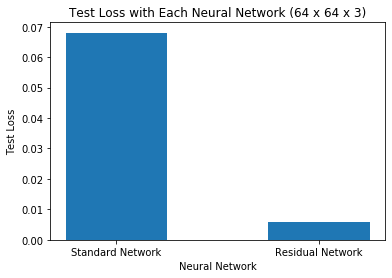

In [29]:
# Plotting the Test Loss

MethodAxis = ['Standard Network', 'Residual Network']
LossAxis64 = [Standard_Test_Loss64, ResNet_Test_Loss64]
plt.bar(MethodAxis, LossAxis64, width = 0.5)
plt.xlabel('Neural Network')
plt.ylabel('Test Loss')
plt.title('Test Loss with Each Neural Network (64 x 64 x 3)')
plt.show()

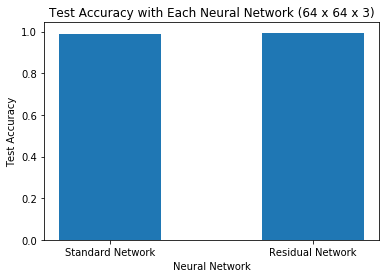

In [30]:
# Plotting the Test Accuracy

AccuracyAxis64 = [Standard_Test_Accuracy64, ResNet_Test_Accuracy64]
plt.bar(MethodAxis, AccuracyAxis64, width = 0.5)
plt.xlabel('Neural Network')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy with Each Neural Network (64 x 64 x 3)')
plt.show()

### Preparing the 32 x 32 x 3 Images

In [31]:
# Importing every image from the positive dataset and turning each image into an array

Images_Positive32 = []
X_Positive32 = []
for filename in glob.glob('Documents/Manhattan College/Fall 2021/MATG 691/MATG 691 Project/Aria Data/COVID-19_Lung_CT_Scans/COVID-19 (944 Images)/*.png'):
    Image_Positive32 = image.load_img(filename, target_size = (32, 32))
    x_Positive32 = image.img_to_array(Image_Positive32)
    Images_Positive32.append(Image_Positive32)
    X_Positive32.append(x_Positive32)

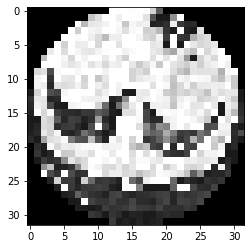

In [32]:
imshow(Images_Positive32[851])

In [33]:
# Importing every image from the negative dataset and turning each image into an array

Images_Negative32 = []
X_Negative32 = []
for filename in glob.glob('Documents/Manhattan College/Fall 2021/MATG 691/MATG 691 Project/Aria Data/COVID-19_Lung_CT_Scans/Non-COVID-19/*.png'):
    Image_Negative32 = image.load_img(filename, target_size = (32, 32))
    x_Negative32 = image.img_to_array(Image_Negative32)
    Images_Negative32.append(Image_Negative32)
    X_Negative32.append(x_Negative32)

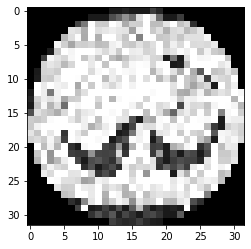

In [34]:
imshow(Images_Negative32[821])

In [35]:
# Standardizing the image arrays

for i in range(len(X_Positive32)):
    X_Positive32[i] = X_Positive32[i]/255.0
    
for i in range(len(X_Negative32)):
    X_Negative32[i] = X_Negative32[i]/255.0

In [36]:
# Creating X and Y by stacking the positive and negative image arrays

X32 = np.vstack((X_Positive32, X_Negative32))
Y32 = np.hstack((Y_Positive, Y_Negative))

In [37]:
# Splitting X and Y into train and test sets

X_Train32, X_Test32, Y_Train32, Y_Test32 = train_test_split(X32, Y32, test_size = 0.1, random_state = 42)

### Using a Standard Convolutional Neural Network with 32 x 32 x 3 Images

In [38]:
# Creating the model

def StandardModel32(input_shape = (32, 32, 3), classes = 1):
    """
    Stage-wise implementation of the architecture of the standard convolutional neural network for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK (no skip connection) -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Three layers of zero padding are placed around the input
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # For Stage 1, a convolutional layer is applied to the input with filter size 64 x 64 and a stride of 2
    # This is followed by batch normalization and a ReLU activation
    # Lastly, a max pooling layer is applied with filter size 3 x 3 and a stride of 2
    
    
    # Stage 2
    X = convolutional_block_standard(X, f = 3, filters = [64, 64, 256], s = 1)

    # For Stage 2, the standard convolutional block function is applied to the input with filter sizes of 64 x 64, 64 x 64, and 256 x 256
    
    ## AVGPOOL
    X = AveragePooling2D(pool_size = (2, 2))(X)

    # An average pooling filter is applied to the input with a filter size 2 x 2
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # The final section involves flattening the input into a vector
    # The vector is then passed through a dense neural network layer with sigmoid activation

    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [39]:
Standard_Model32 = StandardModel32(input_shape = (32, 32, 3), classes = 1)

# Compile the model
Standard_Model32.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
Standard_Model32.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 38, 38, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_8 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 64)          4160

In [40]:
# Training the model
Standard_History32 = Standard_Model32.fit(X_Train32, Y_Train32, epochs = 200, batch_size = 8)

Epoch 1/200
213/213 [==============================] - ETA: 1:56 - loss: 1.2039 - accuracy: 0.25 - ETA: 2s - loss: 0.7250 - accuracy: 0.6250 - ETA: 2s - loss: 0.5420 - accuracy: 0.75 - ETA: 1s - loss: 0.5459 - accuracy: 0.76 - ETA: 1s - loss: 0.4807 - accuracy: 0.78 - ETA: 1s - loss: 0.4561 - accuracy: 0.80 - ETA: 1s - loss: 0.4046 - accuracy: 0.82 - ETA: 1s - loss: 0.4007 - accuracy: 0.82 - ETA: 1s - loss: 0.3944 - accuracy: 0.82 - ETA: 1s - loss: 0.3859 - accuracy: 0.82 - ETA: 1s - loss: 0.3835 - accuracy: 0.82 - ETA: 1s - loss: 0.3868 - accuracy: 0.83 - ETA: 1s - loss: 0.3808 - accuracy: 0.83 - ETA: 1s - loss: 0.3674 - accuracy: 0.83 - ETA: 1s - loss: 0.3563 - accuracy: 0.84 - ETA: 1s - loss: 0.3529 - accuracy: 0.84 - ETA: 1s - loss: 0.3559 - accuracy: 0.84 - ETA: 0s - loss: 0.3557 - accuracy: 0.84 - ETA: 0s - loss: 0.3556 - accuracy: 0.84 - ETA: 0s - loss: 0.3568 - accuracy: 0.84 - ETA: 0s - loss: 0.3569 - accuracy: 0.84 - ETA: 0s - loss: 0.3551 - accuracy: 0.84 - ETA: 0s - loss: 0

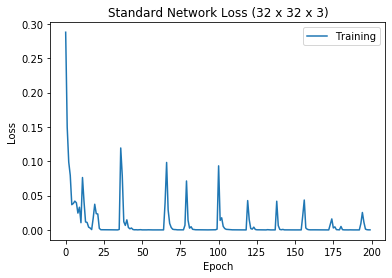

In [41]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History32.history['loss'])
plt.title('Standard Network Loss (32 x 32 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

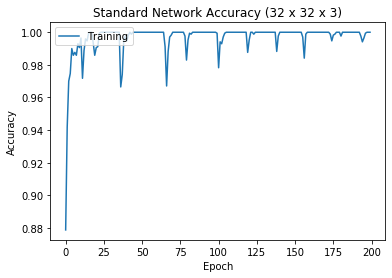

In [42]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History32.history['accuracy'])
plt.title('Standard Network Accuracy (32 x 32 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper left')
plt.show()

In [43]:
# Testing the model
Standard_Test_Loss32, Standard_Test_Accuracy32 = Standard_Model32.evaluate(X_Test32, Y_Test32)

6/6 [==============================] - ETA: 0s - loss: 5.1981e-04 - accuracy: 1.00 - 0s 7ms/step - loss: 0.0121 - accuracy: 0.9947


In [44]:
print('Test Loss:', Standard_Test_Loss32)
print('Test Accuracy:', Standard_Test_Accuracy32)

Test Loss: 0.012095758691430092
Test Accuracy: 0.9947090148925781


### Using a Residual Network with 32 x 32 x 3 Images

In [45]:
# Creating the model

def ResNet32(input_shape = (32, 32, 3), classes = 1):
    """
    Stage-wise implementation of the architecture of the standard convolutional neural network for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK (skip connection) -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Three layers of zero padding are placed around the input
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # For Stage 1, a convolutional layer is applied to the input with filter size 64 x 64 and a stride of 2
    # This is followed by batch normalization and a ReLU activation
    # Lastly, a max pooling layer is applied with filter size 3 x 3 and a stride of 2
    
    # Stage 2
    X = convolutional_block_skip(X, f = 3, filters = [64, 64, 256], s = 1)

    # For Stage 2, the convolutional block function with a skip connection is applied to the input with filter sizes of 64 x 64, 64 x 64, and 256 x 256
    
    ## AVGPOOL
    X = AveragePooling2D(pool_size = (2, 2))(X)
    
    # An average pooling filter is applied to the input with a filter size 2 x 2    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # The final section involves flattening the input into a vector
    # The vector is then passed through a dense neural network layer with sigmoid activation
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [46]:
ResNet_Model32 = ResNet32(input_shape = (32, 32, 3), classes = 1)

# Compile the model
ResNet_Model32.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
print(ResNet_Model32.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 38, 38, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 16, 16, 64)   9472        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 16, 16, 64)   256         conv2d_13[0][0]                  
____________________________________________________________________________________________

In [47]:
# Training the model
ResNet_History32 = ResNet_Model32.fit(X_Train32, Y_Train32, epochs = 200, batch_size = 8)

Epoch 1/200
213/213 [==============================] - ETA: 3:13 - loss: 1.6370 - accuracy: 0.0000e+ - ETA: 2s - loss: 1.1067 - accuracy: 0.5208     - ETA: 2s - loss: 0.7669 - accuracy: 0.65 - ETA: 1s - loss: 0.7310 - accuracy: 0.67 - ETA: 1s - loss: 0.5992 - accuracy: 0.72 - ETA: 1s - loss: 0.5311 - accuracy: 0.76 - ETA: 1s - loss: 0.5229 - accuracy: 0.76 - ETA: 1s - loss: 0.4895 - accuracy: 0.77 - ETA: 1s - loss: 0.4731 - accuracy: 0.78 - ETA: 1s - loss: 0.4427 - accuracy: 0.79 - ETA: 1s - loss: 0.4570 - accuracy: 0.80 - ETA: 1s - loss: 0.4364 - accuracy: 0.80 - ETA: 1s - loss: 0.4257 - accuracy: 0.81 - ETA: 1s - loss: 0.4276 - accuracy: 0.81 - ETA: 1s - loss: 0.4179 - accuracy: 0.81 - ETA: 1s - loss: 0.4193 - accuracy: 0.82 - ETA: 1s - loss: 0.4089 - accuracy: 0.83 - ETA: 0s - loss: 0.3977 - accuracy: 0.83 - ETA: 0s - loss: 0.3933 - accuracy: 0.83 - ETA: 0s - loss: 0.3948 - accuracy: 0.83 - ETA: 0s - loss: 0.3906 - accuracy: 0.83 - ETA: 0s - loss: 0.3903 - accuracy: 0.83 - ETA: 0s -

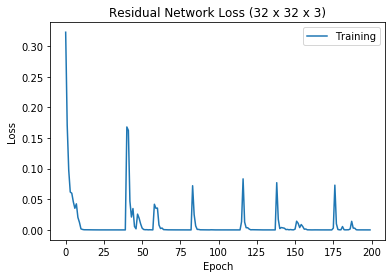

In [48]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(ResNet_History32.history['loss'])
plt.title('Residual Network Loss (32 x 32 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

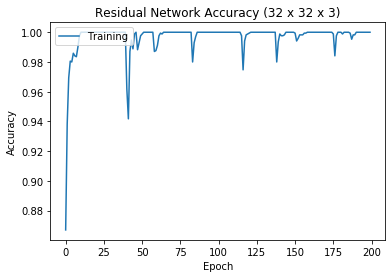

In [49]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(ResNet_History32.history['accuracy'])
plt.title('Residual Network Accuracy (32 x 32 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper left')
plt.show()

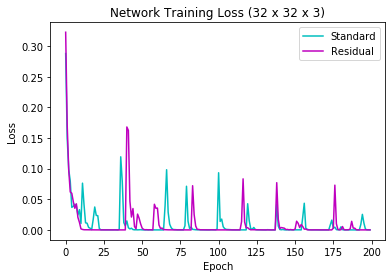

In [50]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History32.history['loss'], color = 'c')
plt.plot(ResNet_History32.history['loss'], color = 'm')
plt.title('Network Training Loss (32 x 32 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Standard', 'Residual'], loc='upper right')
plt.show()

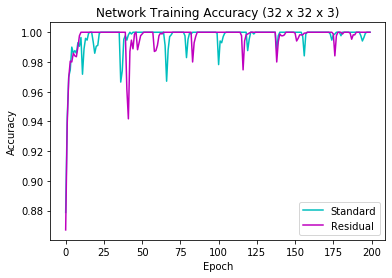

In [51]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History32.history['accuracy'], color = 'c')
plt.plot(ResNet_History32.history['accuracy'], color = 'm')
plt.title('Network Training Accuracy (32 x 32 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Standard', 'Residual'], loc='lower right')
plt.show()

In [52]:
# Testing the model
ResNet_Test_Loss32, ResNet_Test_Accuracy32 = ResNet_Model32.evaluate(X_Test32, Y_Test32)

6/6 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 1.00 - 0s 9ms/step - loss: 0.0656 - accuracy: 0.9841


In [53]:
print('Test Loss:', ResNet_Test_Loss32)
print('Test Accuracy:', ResNet_Test_Accuracy32)

Test Loss: 0.0655885636806488
Test Accuracy: 0.9841269850730896


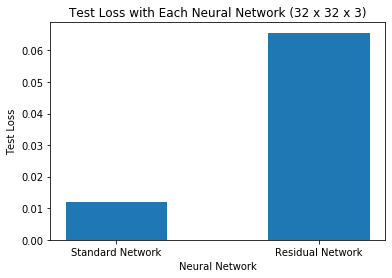

In [54]:
# Plotting the Test Loss

MethodAxis = ['Standard Network', 'Residual Network']
LossAxis32 = [Standard_Test_Loss32, ResNet_Test_Loss32]
plt.bar(MethodAxis, LossAxis32, width = 0.5)
plt.xlabel('Neural Network')
plt.ylabel('Test Loss')
plt.title('Test Loss with Each Neural Network (32 x 32 x 3)')
plt.show()

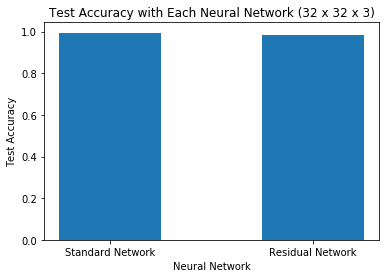

In [55]:
# Plotting the Test Accuracy

AccuracyAxis32 = [Standard_Test_Accuracy32, ResNet_Test_Accuracy32]
plt.bar(MethodAxis, AccuracyAxis32, width = 0.5)
plt.xlabel('Neural Network')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy with Each Neural Network (32 x 32 x 3)')
plt.show()

### Preparing the 16 x 16 x 3 Images

In [56]:
# Importing every image from the positive dataset and turning each image into an array

Images_Positive16 = []
X_Positive16 = []
for filename in glob.glob('Documents/Manhattan College/Fall 2021/MATG 691/MATG 691 Project/Aria Data/COVID-19_Lung_CT_Scans/COVID-19 (944 Images)/*.png'):
    Image_Positive16 = image.load_img(filename, target_size = (16, 16))
    x_Positive16 = image.img_to_array(Image_Positive16)
    Images_Positive16.append(Image_Positive16)
    X_Positive16.append(x_Positive16)

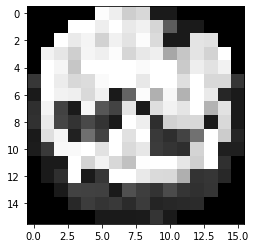

In [57]:
imshow(Images_Positive16[851])

In [58]:
# Importing every image from the negative dataset and turning each image into an array

Images_Negative16 = []
X_Negative16 = []
for filename in glob.glob('Documents/Manhattan College/Fall 2021/MATG 691/MATG 691 Project/Aria Data/COVID-19_Lung_CT_Scans/Non-COVID-19/*.png'):
    Image_Negative16 = image.load_img(filename, target_size = (16, 16))
    x_Negative16 = image.img_to_array(Image_Negative16)
    Images_Negative16.append(Image_Negative16)
    X_Negative16.append(x_Negative16)

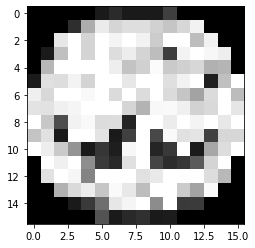

In [59]:
imshow(Images_Negative16[821])

In [60]:
# Standardizing the image arrays

for i in range(len(X_Positive16)):
    X_Positive16[i] = X_Positive16[i]/255.0
    
for i in range(len(X_Negative16)):
    X_Negative16[i] = X_Negative16[i]/255.0

In [61]:
# Creating X and Y by stacking the positive and negative image arrays

X16 = np.vstack((X_Positive16, X_Negative16))
Y16 = np.hstack((Y_Positive, Y_Negative))

In [62]:
# Splitting X and Y into train and test sets

X_Train16, X_Test16, Y_Train16, Y_Test16 = train_test_split(X16, Y16, test_size = 0.1, random_state = 42)

### Using a Standard Convolutional Neural Network with 16 x 16 x 3 Images

In [63]:
# Creating the model

def StandardModel16(input_shape = (16, 16, 3), classes = 1):
    """
    Stage-wise implementation of the architecture of the standard convolutional neural network for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK (no skip connection) -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Three layers of zero padding are placed around the input
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # For Stage 1, a convolutional layer is applied to the input with filter size 64 x 64 and a stride of 2
    # This is followed by batch normalization and a ReLU activation
    # Lastly, a max pooling layer is applied with filter size 3 x 3 and a stride of 2

    # Stage 2
    X = convolutional_block_standard(X, f = 3, filters = [64, 64, 256], s = 1)

    # For Stage 2, the standard convolutional block function is applied to the input with filter sizes of 64 x 64, 64 x 64, and 256 x 256
    
    ## AVGPOOL
    X = AveragePooling2D(pool_size = (2, 2))(X)

    # An average pooling filter is applied to the input with a filter size 2 x 2
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # The final section involves flattening the input into a vector
    # The vector is then passed through a dense neural network layer with sigmoid activation
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [64]:
Standard_Model16 = StandardModel16(input_shape = (16, 16, 3), classes = 1)

# Compile the model
Standard_Model16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
Standard_Model16.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 16, 16, 3)]       0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 22, 22, 3)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 64)          9472      
_________________________________________________________________
batch_normalization_18 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
activation_16 (Activation)   (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 3, 3, 64)          4160

In [65]:
# Training the model
Standard_History16 = Standard_Model16.fit(X_Train16, Y_Train16, epochs = 200, batch_size = 8)

Epoch 1/200
213/213 [==============================] - ETA: 1:49 - loss: 1.2679 - accuracy: 0.12 - ETA: 0s - loss: 0.5086 - accuracy: 0.7569 - ETA: 0s - loss: 0.4611 - accuracy: 0.80 - ETA: 0s - loss: 0.4394 - accuracy: 0.80 - ETA: 0s - loss: 0.4098 - accuracy: 0.81 - ETA: 0s - loss: 0.4008 - accuracy: 0.82 - ETA: 0s - loss: 0.4030 - accuracy: 0.82 - ETA: 0s - loss: 0.4071 - accuracy: 0.82 - ETA: 0s - loss: 0.4017 - accuracy: 0.82 - ETA: 0s - loss: 0.4041 - accuracy: 0.82 - ETA: 0s - loss: 0.3886 - accuracy: 0.83 - ETA: 0s - loss: 0.3791 - accuracy: 0.83 - ETA: 0s - loss: 0.3697 - accuracy: 0.84 - ETA: 0s - loss: 0.3662 - accuracy: 0.85 - 1s 4ms/step - loss: 0.3578 - accuracy: 0.8546
Epoch 2/200
213/213 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 1.00 - ETA: 0s - loss: 0.2229 - accuracy: 0.93 - ETA: 0s - loss: 0.2167 - accuracy: 0.93 - ETA: 0s - loss: 0.1953 - accuracy: 0.94 - ETA: 0s - loss: 0.1967 - accuracy: 0.94 - ETA: 0s - loss: 0.1931 - accuracy: 0.93 - 

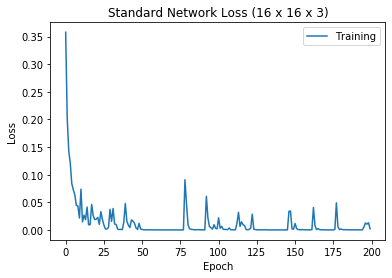

In [66]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History16.history['loss'])
plt.title('Standard Network Loss (16 x 16 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

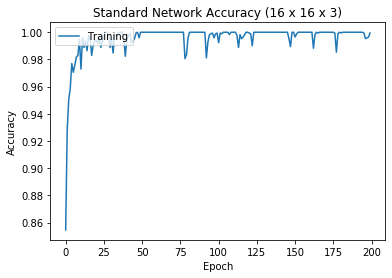

In [67]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History16.history['accuracy'])
plt.title('Standard Network Accuracy (16 x 16 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper left')
plt.show()

In [68]:
# Testing the model
Standard_Test_Loss16, Standard_Test_Accuracy16 = Standard_Model16.evaluate(X_Test16, Y_Test16)

6/6 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.96 - 0s 6ms/step - loss: 0.1050 - accuracy: 0.9788


In [69]:
print('Test Loss:', Standard_Test_Loss16)
print('Test Accuracy:', Standard_Test_Accuracy16)

Test Loss: 0.10500075668096542
Test Accuracy: 0.9788359999656677


### Using a Residual Network with 16 x 16 x 3 Images

In [70]:
# Creating the model

def ResNet16(input_shape = (16, 16, 3), classes = 1):
    """
    Stage-wise implementation of the architecture of the standard convolutional neural network for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK (skip connection) -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Three layers of zero padding are placed around the input
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # For Stage 1, a convolutional layer is applied to the input with filter size 64 x 64 and a stride of 2
    # This is followed by batch normalization and a ReLU activation
    # Lastly, a max pooling layer is applied with filter size 3 x 3 and a stride of 2

    # Stage 2
    X = convolutional_block_skip(X, f = 3, filters = [64, 64, 256], s = 1)

    # For Stage 2, the convolutional block function with a skip connection is applied to the input with filter sizes of 64 x 64, 64 x 64, and 256 x 256
    
    ## AVGPOOL
    X = AveragePooling2D(pool_size = (2, 2))(X)

    # An average pooling filter is applied to the input with a filter size 2 x 2
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # The final section involves flattening the input into a vector
    # The vector is then passed through a dense neural network layer with sigmoid activation

    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [71]:
ResNet_Model16 = ResNet16(input_shape = (16, 16, 3), classes = 1)

# Compile the model
ResNet_Model16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
print(ResNet_Model16.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 16, 16, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 22, 22, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 8, 8, 64)     9472        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 8, 8, 64)     256         conv2d_22[0][0]                  
____________________________________________________________________________________________

In [72]:
# Training the model
ResNet_History16 = ResNet_Model16.fit(X_Train16, Y_Train16, epochs = 200, batch_size = 8)

Epoch 1/200
213/213 [==============================] - ETA: 2:09 - loss: 0.7399 - accuracy: 0.50 - ETA: 1s - loss: 0.4746 - accuracy: 0.7604 - ETA: 1s - loss: 0.5433 - accuracy: 0.73 - ETA: 0s - loss: 0.4519 - accuracy: 0.78 - ETA: 0s - loss: 0.4363 - accuracy: 0.79 - ETA: 0s - loss: 0.4034 - accuracy: 0.81 - ETA: 0s - loss: 0.3843 - accuracy: 0.82 - ETA: 0s - loss: 0.3734 - accuracy: 0.83 - ETA: 0s - loss: 0.3758 - accuracy: 0.82 - ETA: 0s - loss: 0.3838 - accuracy: 0.82 - ETA: 0s - loss: 0.3679 - accuracy: 0.83 - ETA: 0s - loss: 0.3661 - accuracy: 0.83 - ETA: 0s - loss: 0.3592 - accuracy: 0.83 - ETA: 0s - loss: 0.3486 - accuracy: 0.84 - ETA: 0s - loss: 0.3414 - accuracy: 0.84 - ETA: 0s - loss: 0.3347 - accuracy: 0.84 - ETA: 0s - loss: 0.3421 - accuracy: 0.84 - ETA: 0s - loss: 0.3398 - accuracy: 0.84 - ETA: 0s - loss: 0.3428 - accuracy: 0.84 - 2s 5ms/step - loss: 0.3415 - accuracy: 0.8440
Epoch 2/200
213/213 [==============================] - ETA: 0s - loss: 0.2044 - accuracy: 1.00 - 

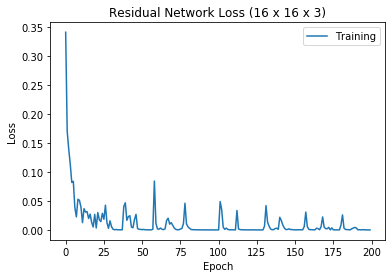

In [73]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(ResNet_History16.history['loss'])
plt.title('Residual Network Loss (16 x 16 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

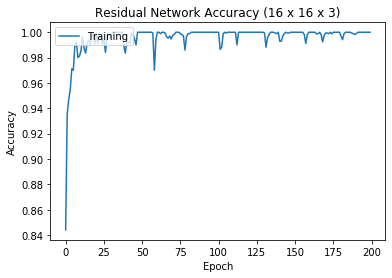

In [74]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(ResNet_History16.history['accuracy'])
plt.title('Residual Network Accuracy (16 x 16 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper left')
plt.show()

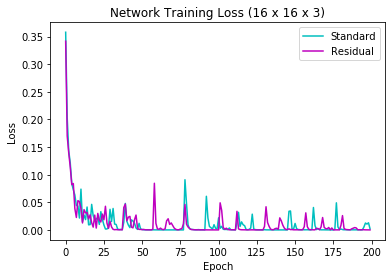

In [75]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History16.history['loss'], color = 'c')
plt.plot(ResNet_History16.history['loss'], color = 'm')
plt.title('Network Training Loss (16 x 16 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Standard', 'Residual'], loc='upper right')
plt.show()

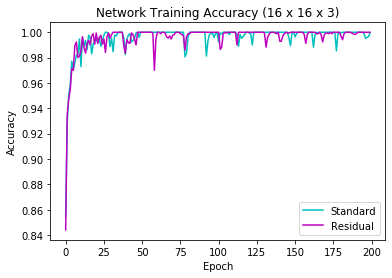

In [76]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History16.history['accuracy'], color = 'c')
plt.plot(ResNet_History16.history['accuracy'], color = 'm')
plt.title('Network Training Accuracy (16 x 16 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Standard', 'Residual'], loc='lower right')
plt.show()

In [77]:
# Testing the model
ResNet_Test_Loss16, ResNet_Test_Accuracy16 = ResNet_Model16.evaluate(X_Test16, Y_Test16)

6/6 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 1.00 - 0s 3ms/step - loss: 0.2236 - accuracy: 0.9683


In [78]:
print('Test Loss:', ResNet_Test_Loss16)
print('Test Accuracy:', ResNet_Test_Accuracy16)

Test Loss: 0.22360222041606903
Test Accuracy: 0.9682539701461792


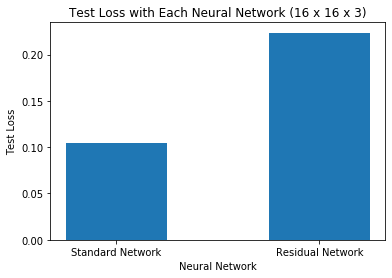

In [79]:
# Plotting the Test Loss

MethodAxis = ['Standard Network', 'Residual Network']
LossAxis16 = [Standard_Test_Loss16, ResNet_Test_Loss16]
plt.bar(MethodAxis, LossAxis16, width = 0.5)
plt.xlabel('Neural Network')
plt.ylabel('Test Loss')
plt.title('Test Loss with Each Neural Network (16 x 16 x 3)')
plt.show()

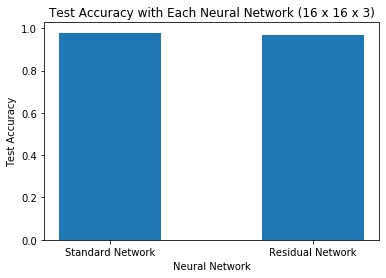

In [80]:
# Plotting the Test Accuracy

AccuracyAxis16 = [Standard_Test_Accuracy16, ResNet_Test_Accuracy16]
plt.bar(MethodAxis, AccuracyAxis16, width = 0.5)
plt.xlabel('Neural Network')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy with Each Neural Network (16 x 16 x 3)')
plt.show()

### Preparing the 8 x 8 x 3 Images

In [81]:
# Importing every image from the positive dataset and turning each image into an array

Images_Positive8 = []
X_Positive8 = []
for filename in glob.glob('Documents/Manhattan College/Fall 2021/MATG 691/MATG 691 Project/Aria Data/COVID-19_Lung_CT_Scans/COVID-19 (944 Images)/*.png'):
    Image_Positive8 = image.load_img(filename, target_size = (8, 8))
    x_Positive8 = image.img_to_array(Image_Positive8)
    Images_Positive8.append(Image_Positive8)
    X_Positive8.append(x_Positive8)

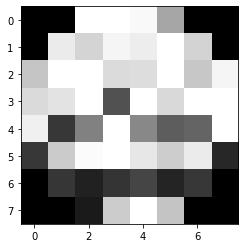

In [82]:
imshow(Images_Positive8[851])

In [83]:
# Importing every image from the negative dataset and turning each image into an array

Images_Negative8 = []
X_Negative8 = []
for filename in glob.glob('Documents/Manhattan College/Fall 2021/MATG 691/MATG 691 Project/Aria Data/COVID-19_Lung_CT_Scans/Non-COVID-19/*.png'):
    Image_Negative8 = image.load_img(filename, target_size = (8, 8))
    x_Negative8 = image.img_to_array(Image_Negative8)
    Images_Negative8.append(Image_Negative8)
    X_Negative8.append(x_Negative8)

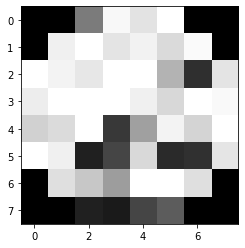

In [84]:
imshow(Images_Negative8[821])

In [85]:
# Standardizing the image arrays

for i in range(len(X_Positive8)):
    X_Positive8[i] = X_Positive8[i]/255.0
    
for i in range(len(X_Negative8)):
    X_Negative8[i] = X_Negative8[i]/255.0

In [86]:
# Creating X and Y by stacking the positive and negative image arrays

X8 = np.vstack((X_Positive8, X_Negative8))
Y8 = np.hstack((Y_Positive, Y_Negative))

In [87]:
# Splitting X and Y into train and test sets

X_Train8, X_Test8, Y_Train8, Y_Test8 = train_test_split(X8, Y8, test_size = 0.1, random_state = 42)

### Using a Standard Convolutional Neural Network with 8 x 8 x 3 Images

In [88]:
# Creating the model

def StandardModel8(input_shape = (8, 8, 3), classes = 1):
    """
    Stage-wise implementation of the architecture of the standard convolutional neural network for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK (no skip connection) -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Zero-Padding
    X = ZeroPadding2D((4, 4))(X_input)
    
    # Four layers of zero padding are placed around the input
    # The amount of padding is increased to compensate for the smaller input array
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # For Stage 1, a convolutional layer is applied to the input with filter size 64 x 64 and a stride of 2
    # This is followed by batch normalization and a ReLU activation
    # Lastly, a max pooling layer is applied with filter size 3 x 3 and a stride of 2

    # Stage 2
    X = convolutional_block_standard(X, f = 3, filters = [64, 64, 256], s = 1)

    # For Stage 2, the standard convolutional block function is applied to the input with filter sizes of 64 x 64, 64 x 64, and 256 x 256
    
    ## AVGPOOL
    X = AveragePooling2D(pool_size = (2, 2))(X)
    
    # An average pooling filter is applied to the input with a filter size 2 x 2

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # The final section involves flattening the input into a vector
    # The vector is then passed through a dense neural network layer with sigmoid activation

    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [89]:
Standard_Model8 = StandardModel8(input_shape = (8, 8, 3), classes = 1)

# Compile the model
Standard_Model8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
Standard_Model8.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 8, 8, 3)]         0         
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 5, 5, 64)          9472      
_________________________________________________________________
batch_normalization_27 (Batc (None, 5, 5, 64)          256       
_________________________________________________________________
activation_24 (Activation)   (None, 5, 5, 64)          0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 2, 2, 64)          4160

In [90]:
# Training the model
Standard_History8 = Standard_Model8.fit(X_Train8, Y_Train8, epochs = 200, batch_size = 8)

Epoch 1/200
213/213 [==============================] - ETA: 2:03 - loss: 1.0090 - accuracy: 0.25 - ETA: 0s - loss: 0.5472 - accuracy: 0.7437 - ETA: 0s - loss: 0.5037 - accuracy: 0.75 - ETA: 0s - loss: 0.4783 - accuracy: 0.76 - ETA: 0s - loss: 0.4490 - accuracy: 0.78 - ETA: 0s - loss: 0.4126 - accuracy: 0.80 - ETA: 0s - loss: 0.4054 - accuracy: 0.81 - ETA: 0s - loss: 0.3916 - accuracy: 0.82 - ETA: 0s - loss: 0.3906 - accuracy: 0.82 - ETA: 0s - loss: 0.3859 - accuracy: 0.82 - ETA: 0s - loss: 0.3739 - accuracy: 0.83 - 1s 3ms/step - loss: 0.3705 - accuracy: 0.8381
Epoch 2/200
213/213 [==============================] - ETA: 0s - loss: 1.0934 - accuracy: 0.75 - ETA: 0s - loss: 0.3749 - accuracy: 0.89 - ETA: 0s - loss: 0.3471 - accuracy: 0.87 - ETA: 0s - loss: 0.3289 - accuracy: 0.87 - ETA: 0s - loss: 0.3093 - accuracy: 0.88 - ETA: 0s - loss: 0.2984 - accuracy: 0.88 - ETA: 0s - loss: 0.2921 - accuracy: 0.88 - ETA: 0s - loss: 0.2849 - accuracy: 0.88 - ETA: 0s - loss: 0.2882 - accuracy: 0.88 - 

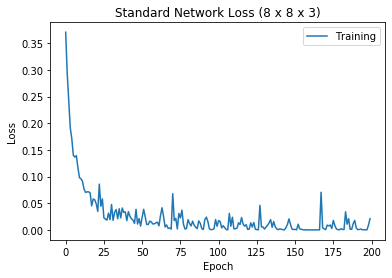

In [91]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History8.history['loss'])
plt.title('Standard Network Loss (8 x 8 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

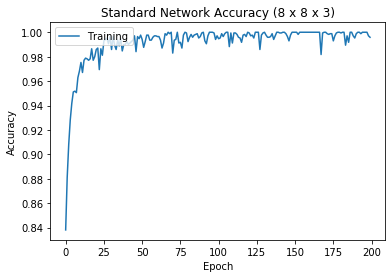

In [92]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History8.history['accuracy'])
plt.title('Standard Network Accuracy (8 x 8 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper left')
plt.show()

In [93]:
# Testing the model
Standard_Test_Loss8, Standard_Test_Accuracy8 = Standard_Model8.evaluate(X_Test8, Y_Test8)

6/6 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.96 - 0s 3ms/step - loss: 0.0991 - accuracy: 0.9841


In [94]:
print('Test Loss:', Standard_Test_Loss8)
print('Test Accuracy:', Standard_Test_Accuracy8)

Test Loss: 0.09912817925214767
Test Accuracy: 0.9841269850730896


### Using a Residual Network with 8 x 8 x 3 Images

In [95]:
# Creating the model

def ResNet8(input_shape = (8, 8, 3), classes = 1):
    """
    Stage-wise implementation of the architecture of the standard convolutional neural network for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK (skip connection) -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((4, 4))(X_input)
    
    # Four layers of zero padding are placed around the input
    # The amount of padding is increased to compensate for the smaller input array
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # For Stage 1, a convolutional layer is applied to the input with filter size 64 x 64 and a stride of 2
    # This is followed by batch normalization and a ReLU activation
    # Lastly, a max pooling layer is applied with filter size 3 x 3 and a stride of 2
    
    # Stage 2
    X = convolutional_block_skip(X, f = 3, filters = [64, 64, 256], s = 1)

    # For Stage 2, the convolutional block function with a skip connection is applied to the input with filter sizes of 64 x 64, 64 x 64, and 256 x 256
    
    ## AVGPOOL
    X = AveragePooling2D(pool_size = (2, 2))(X)

    # An average pooling filter is applied to the input with a filter size 2 x 2
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # The final section involves flattening the input into a vector
    # The vector is then passed through a dense neural network layer with sigmoid activation
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [96]:
ResNet_Model8 = ResNet8(input_shape = (8, 8, 3), classes = 1)

# Compile the model
ResNet_Model8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
print(ResNet_Model8.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 8, 8, 3)]    0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 16, 16, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 5, 5, 64)     9472        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 5, 5, 64)     256         conv2d_31[0][0]                  
____________________________________________________________________________________________

In [97]:
# Training the model
ResNet_History8 = ResNet_Model8.fit(X_Train8, Y_Train8, epochs = 200, batch_size = 8)

Epoch 1/200
213/213 [==============================] - ETA: 2:39 - loss: 0.7373 - accuracy: 0.37 - ETA: 0s - loss: 0.4596 - accuracy: 0.7734 - ETA: 0s - loss: 0.4165 - accuracy: 0.79 - ETA: 0s - loss: 0.4330 - accuracy: 0.78 - ETA: 0s - loss: 0.4527 - accuracy: 0.77 - ETA: 0s - loss: 0.4499 - accuracy: 0.77 - ETA: 0s - loss: 0.4349 - accuracy: 0.79 - ETA: 0s - loss: 0.4349 - accuracy: 0.79 - ETA: 0s - loss: 0.4192 - accuracy: 0.80 - ETA: 0s - loss: 0.4083 - accuracy: 0.81 - ETA: 0s - loss: 0.4054 - accuracy: 0.81 - ETA: 0s - loss: 0.3939 - accuracy: 0.82 - ETA: 0s - loss: 0.4014 - accuracy: 0.82 - ETA: 0s - loss: 0.3912 - accuracy: 0.82 - ETA: 0s - loss: 0.3855 - accuracy: 0.83 - ETA: 0s - loss: 0.3788 - accuracy: 0.83 - ETA: 0s - loss: 0.3771 - accuracy: 0.83 - 2s 4ms/step - loss: 0.3774 - accuracy: 0.8358
Epoch 2/200
213/213 [==============================] - ETA: 1s - loss: 0.1787 - accuracy: 0.87 - ETA: 0s - loss: 0.2263 - accuracy: 0.89 - ETA: 0s - loss: 0.2400 - accuracy: 0.89 - 

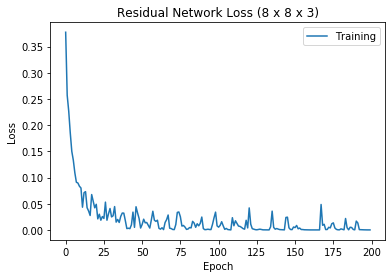

In [98]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(ResNet_History8.history['loss'])
plt.title('Residual Network Loss (8 x 8 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

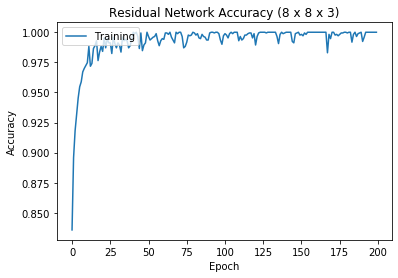

In [99]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(ResNet_History8.history['accuracy'])
plt.title('Residual Network Accuracy (8 x 8 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper left')
plt.show()

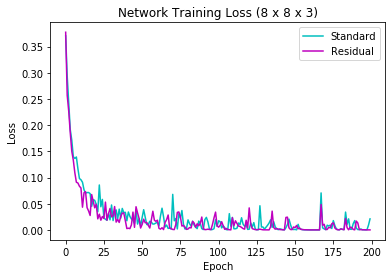

In [100]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History8.history['loss'], color = 'c')
plt.plot(ResNet_History8.history['loss'], color = 'm')
plt.title('Network Training Loss (8 x 8 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Standard', 'Residual'], loc='upper right')
plt.show()

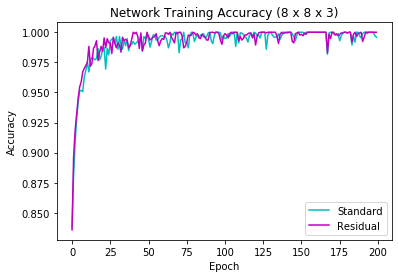

In [101]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History8.history['accuracy'], color = 'c')
plt.plot(ResNet_History8.history['accuracy'], color = 'm')
plt.title('Network Training Accuracy (8 x 8 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Standard', 'Residual'], loc='lower right')
plt.show()

In [102]:
# Testing the model
ResNet_Test_Loss8, ResNet_Test_Accuracy8 = ResNet_Model8.evaluate(X_Test8, Y_Test8)

6/6 [==============================] - ETA: 0s - loss: 4.4202e-04 - accuracy: 1.00 - 0s 3ms/step - loss: 0.1657 - accuracy: 0.9841


In [103]:
print('Test Loss:', ResNet_Test_Loss8)
print('Test Accuracy:', ResNet_Test_Accuracy8)

Test Loss: 0.165664941072464
Test Accuracy: 0.9841269850730896


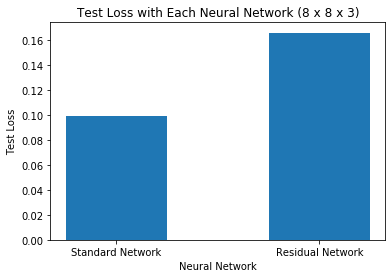

In [104]:
# Plotting the Test Loss

MethodAxis = ['Standard Network', 'Residual Network']
LossAxis8 = [Standard_Test_Loss8, ResNet_Test_Loss8]
plt.bar(MethodAxis, LossAxis8, width = 0.5)
plt.xlabel('Neural Network')
plt.ylabel('Test Loss')
plt.title('Test Loss with Each Neural Network (8 x 8 x 3)')
plt.show()

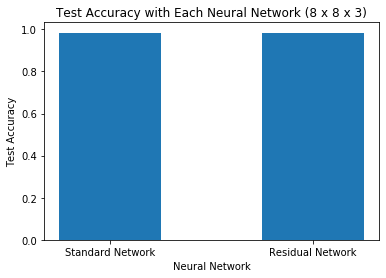

In [105]:
# Plotting the Test Accuracy

AccuracyAxis8 = [Standard_Test_Accuracy8, ResNet_Test_Accuracy8]
plt.bar(MethodAxis, AccuracyAxis8, width = 0.5)
plt.xlabel('Neural Network')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy with Each Neural Network (8 x 8 x 3)')
plt.show()

### Preparing the 4 x 4 x 3 Images

In [106]:
# Importing every image from the positive dataset and turning each image into an array

Images_Positive4 = []
X_Positive4 = []
for filename in glob.glob('Documents/Manhattan College/Fall 2021/MATG 691/MATG 691 Project/Aria Data/COVID-19_Lung_CT_Scans/COVID-19 (944 Images)/*.png'):
    Image_Positive4 = image.load_img(filename, target_size = (4, 4))
    x_Positive4 = image.img_to_array(Image_Positive4)
    Images_Positive4.append(Image_Positive4)
    X_Positive4.append(x_Positive4)

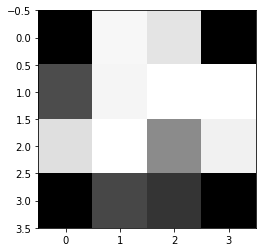

In [107]:
imshow(Images_Positive4[851])

In [108]:
# Importing every image from the negative dataset and turning each image into an array

Images_Negative4 = []
X_Negative4 = []
for filename in glob.glob('Documents/Manhattan College/Fall 2021/MATG 691/MATG 691 Project/Aria Data/COVID-19_Lung_CT_Scans/Non-COVID-19/*.png'):
    Image_Negative4 = image.load_img(filename, target_size = (4, 4))
    x_Negative4 = image.img_to_array(Image_Negative4)
    Images_Negative4.append(Image_Negative4)
    X_Negative4.append(x_Negative4)

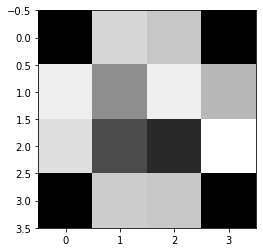

In [109]:
imshow(Images_Negative4[821])

In [110]:
# Standardizing the image arrays

for i in range(len(X_Positive4)):
    X_Positive4[i] = X_Positive4[i]/255.0
    
for i in range(len(X_Negative4)):
    X_Negative4[i] = X_Negative4[i]/255.0

In [111]:
# Creating X and Y by stacking the positive and negative image arrays

X4 = np.vstack((X_Positive4, X_Negative4))
Y4 = np.hstack((Y_Positive, Y_Negative))

In [112]:
# Splitting X and Y into train and test sets

X_Train4, X_Test4, Y_Train4, Y_Test4 = train_test_split(X4, Y4, test_size = 0.1, random_state = 42)

### Using a Standard Convolutional Neural Network with 4 x 4 x 3 Images

In [113]:
# Creating the model

def StandardModel4(input_shape = (4, 4, 3), classes = 1):
    """
    Stage-wise implementation of the architecture of the standard convolutional neural network for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK (no skip connection) -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((6, 6))(X_input)
    
    # Six layers of zero padding are placed around the input
    # The amount of padding is increased to compensate for the smaller input array
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # For Stage 1, a convolutional layer is applied to the input with filter size 64 x 64 and a stride of 2
    # This is followed by batch normalization and a ReLU activation
    # Lastly, a max pooling layer is applied with filter size 3 x 3 and a stride of 2

    # Stage 2
    X = convolutional_block_standard(X, f = 3, filters = [64, 64, 256], s = 1)

    # For Stage 2, the standard convolutional block function is applied to the input with filter sizes of 64 x 64, 64 x 64, and 256 x 256
    
    ## AVGPOOL
    X = AveragePooling2D(pool_size = (2, 2))(X)
    
    # An average pooling filter is applied to the input with a filter size 2 x 2

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # The final section involves flattening the input into a vector
    # The vector is then passed through a dense neural network layer with sigmoid activation

    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [114]:
Standard_Model4 = StandardModel4(input_shape = (4, 4, 3), classes = 1)

# Compile the model
Standard_Model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
Standard_Model4.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 4, 4, 3)]         0         
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 5, 5, 64)          9472      
_________________________________________________________________
batch_normalization_36 (Batc (None, 5, 5, 64)          256       
_________________________________________________________________
activation_32 (Activation)   (None, 5, 5, 64)          0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 2, 2, 64)          4160

In [115]:
# Training the model
Standard_History4 = Standard_Model4.fit(X_Train4, Y_Train4, epochs = 200, batch_size = 8)

Epoch 1/200
213/213 [==============================] - ETA: 2:06 - loss: 0.5200 - accuracy: 0.75 - ETA: 0s - loss: 0.5368 - accuracy: 0.7132 - ETA: 0s - loss: 0.5065 - accuracy: 0.73 - ETA: 0s - loss: 0.5016 - accuracy: 0.75 - ETA: 0s - loss: 0.4706 - accuracy: 0.77 - ETA: 0s - loss: 0.4680 - accuracy: 0.78 - ETA: 0s - loss: 0.4871 - accuracy: 0.77 - ETA: 0s - loss: 0.4856 - accuracy: 0.78 - ETA: 0s - loss: 0.4926 - accuracy: 0.78 - ETA: 0s - loss: 0.4808 - accuracy: 0.79 - ETA: 0s - loss: 0.4832 - accuracy: 0.79 - ETA: 0s - loss: 0.4792 - accuracy: 0.79 - ETA: 0s - loss: 0.4767 - accuracy: 0.79 - ETA: 0s - loss: 0.4711 - accuracy: 0.79 - 1s 4ms/step - loss: 0.4684 - accuracy: 0.7964
Epoch 2/200
213/213 [==============================] - ETA: 0s - loss: 0.2102 - accuracy: 0.87 - ETA: 0s - loss: 0.4117 - accuracy: 0.81 - ETA: 0s - loss: 0.4076 - accuracy: 0.82 - ETA: 0s - loss: 0.3970 - accuracy: 0.82 - ETA: 0s - loss: 0.3909 - accuracy: 0.82 - ETA: 0s - loss: 0.3841 - accuracy: 0.83 - 

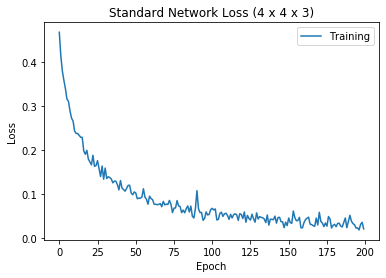

In [116]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History4.history['loss'])
plt.title('Standard Network Loss (4 x 4 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

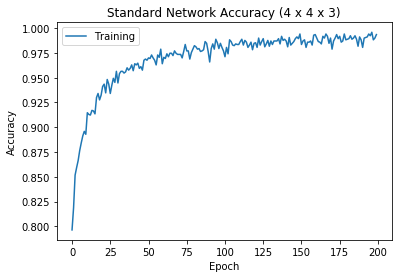

In [117]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History4.history['accuracy'])
plt.title('Standard Network Accuracy (4 x 4 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper left')
plt.show()

In [118]:
# Testing the model
Standard_Test_Loss4, Standard_Test_Accuracy4 = Standard_Model4.evaluate(X_Test4, Y_Test4)

6/6 [==============================] - ETA: 0s - loss: 0.6523 - accuracy: 0.87 - 0s 3ms/step - loss: 0.3007 - accuracy: 0.9259


In [119]:
print('Test Loss:', Standard_Test_Loss4)
print('Test Accuracy:', Standard_Test_Accuracy4)

Test Loss: 0.3007134199142456
Test Accuracy: 0.9259259104728699


### Using a Residual Network with 4 x 4 x 3 Images

In [120]:
# Creating the model

def ResNet4(input_shape = (4, 4, 3), classes = 1):
    """
    Stage-wise implementation of the architecture of the standard convolutional neural network for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK (skip connection) -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((6, 6))(X_input)
    
    # Six layers of zero padding are placed around the input
    # The amount of padding is increased to compensate for the smaller input array

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # For Stage 1, a convolutional layer is applied to the input with filter size 64 x 64 and a stride of 2
    # This is followed by batch normalization and a ReLU activation
    # Lastly, a max pooling layer is applied with filter size 3 x 3 and a stride of 2

    # Stage 2
    X = convolutional_block_skip(X, f = 3, filters = [64, 64, 256], s = 1)

    # For Stage 2, the convolutional block function with a skip connection is applied to the input with filter sizes of 64 x 64, 64 x 64, and 256 x 256
    
    ## AVGPOOL
    X = AveragePooling2D(pool_size = (2, 2))(X)

    # An average pooling filter is applied to the input with a filter size 2 x 2
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # The final section involves flattening the input into a vector
    # The vector is then passed through a dense neural network layer with sigmoid activation

    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [121]:
ResNet_Model4 = ResNet4(input_shape = (4, 4, 3), classes = 1)

# Compile the model
ResNet_Model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
print(ResNet_Model4.summary())

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 4, 4, 3)]    0                                            
__________________________________________________________________________________________________
zero_padding2d_9 (ZeroPadding2D (None, 16, 16, 3)    0           input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 5, 5, 64)     9472        zero_padding2d_9[0][0]           
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 5, 5, 64)     256         conv2d_40[0][0]                  
____________________________________________________________________________________________

In [122]:
# Training the model
ResNet_History4 = ResNet_Model4.fit(X_Train4, Y_Train4, epochs = 200, batch_size = 8)

Epoch 1/200
213/213 [==============================] - ETA: 2:42 - loss: 0.4163 - accuracy: 0.87 - ETA: 0s - loss: 0.6750 - accuracy: 0.7578 - ETA: 0s - loss: 0.5825 - accuracy: 0.79 - ETA: 0s - loss: 0.5738 - accuracy: 0.76 - ETA: 0s - loss: 0.5340 - accuracy: 0.77 - ETA: 0s - loss: 0.5180 - accuracy: 0.78 - ETA: 0s - loss: 0.5134 - accuracy: 0.78 - ETA: 0s - loss: 0.5062 - accuracy: 0.78 - ETA: 0s - loss: 0.5012 - accuracy: 0.79 - ETA: 0s - loss: 0.4967 - accuracy: 0.79 - ETA: 0s - loss: 0.4899 - accuracy: 0.79 - ETA: 0s - loss: 0.4814 - accuracy: 0.79 - ETA: 0s - loss: 0.4782 - accuracy: 0.79 - ETA: 0s - loss: 0.4759 - accuracy: 0.79 - 1s 3ms/step - loss: 0.4761 - accuracy: 0.7981
Epoch 2/200
213/213 [==============================] - ETA: 1s - loss: 0.2239 - accuracy: 1.00 - ETA: 0s - loss: 0.3676 - accuracy: 0.83 - ETA: 0s - loss: 0.3909 - accuracy: 0.82 - ETA: 0s - loss: 0.4288 - accuracy: 0.81 - ETA: 0s - loss: 0.4326 - accuracy: 0.80 - ETA: 0s - loss: 0.4313 - accuracy: 0.80 - 

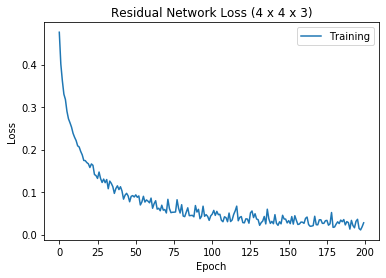

In [123]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(ResNet_History4.history['loss'])
plt.title('Residual Network Loss (4 x 4 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

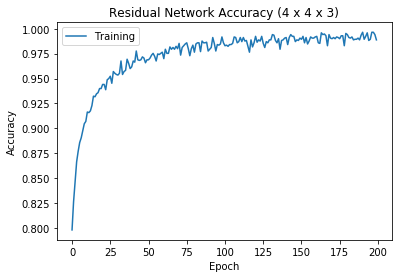

In [124]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(ResNet_History4.history['accuracy'])
plt.title('Residual Network Accuracy (4 x 4 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper left')
plt.show()

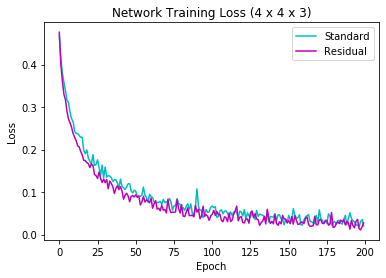

In [125]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History4.history['loss'], color = 'c')
plt.plot(ResNet_History4.history['loss'], color = 'm')
plt.title('Network Training Loss (4 x 4 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Standard', 'Residual'], loc='upper right')
plt.show()

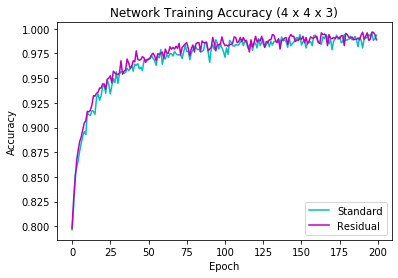

In [126]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History4.history['accuracy'], color = 'c')
plt.plot(ResNet_History4.history['accuracy'], color = 'm')
plt.title('Network Training Accuracy (4 x 4 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Standard', 'Residual'], loc='lower right')
plt.show()

In [127]:
# Testing the model
ResNet_Test_Loss4, ResNet_Test_Accuracy4 = ResNet_Model4.evaluate(X_Test4, Y_Test4)

6/6 [==============================] - ETA: 0s - loss: 0.4574 - accuracy: 0.90 - 0s 1ms/step - loss: 0.2347 - accuracy: 0.9524


In [128]:
print('Test Loss:', ResNet_Test_Loss4)
print('Test Accuracy:', ResNet_Test_Accuracy4)

Test Loss: 0.23466259241104126
Test Accuracy: 0.9523809552192688


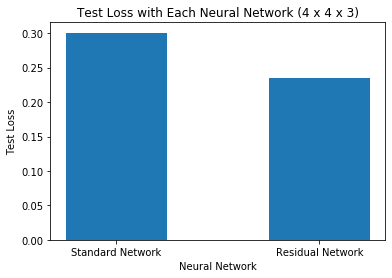

In [129]:
# Plotting the Test Loss

MethodAxis = ['Standard Network', 'Residual Network']
LossAxis4 = [Standard_Test_Loss4, ResNet_Test_Loss4]
plt.bar(MethodAxis, LossAxis4, width = 0.5)
plt.xlabel('Neural Network')
plt.ylabel('Test Loss')
plt.title('Test Loss with Each Neural Network (4 x 4 x 3)')
plt.show()

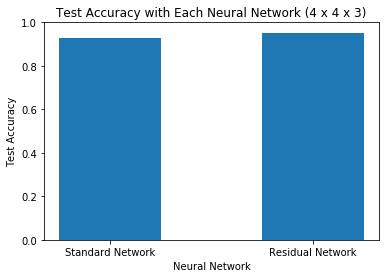

In [130]:
# Plotting the Test Accuracy

AccuracyAxis4 = [Standard_Test_Accuracy4, ResNet_Test_Accuracy4]
plt.bar(MethodAxis, AccuracyAxis4, width = 0.5)
plt.xlabel('Neural Network')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy with Each Neural Network (4 x 4 x 3)')
plt.show()

### Preparing the 2 x 2 x 3 Images

In [131]:
# Importing every image from the positive dataset and turning each image into an array

Images_Positive2 = []
X_Positive2 = []
for filename in glob.glob('Documents/Manhattan College/Fall 2021/MATG 691/MATG 691 Project/Aria Data/COVID-19_Lung_CT_Scans/COVID-19 (944 Images)/*.png'):
    Image_Positive2 = image.load_img(filename, target_size = (2, 2))
    x_Positive2 = image.img_to_array(Image_Positive2)
    Images_Positive2.append(Image_Positive2)
    X_Positive2.append(x_Positive2)

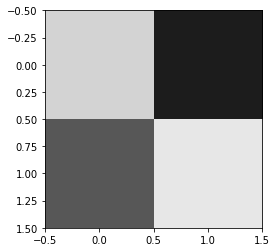

In [132]:
imshow(Images_Positive2[851])

In [133]:
# Importing every image from the negative dataset and turning each image into an array

Images_Negative2 = []
X_Negative2 = []
for filename in glob.glob('Documents/Manhattan College/Fall 2021/MATG 691/MATG 691 Project/Aria Data/COVID-19_Lung_CT_Scans/Non-COVID-19/*.png'):
    Image_Negative2 = image.load_img(filename, target_size = (2, 2))
    x_Negative2 = image.img_to_array(Image_Negative2)
    Images_Negative2.append(Image_Negative2)
    X_Negative2.append(x_Negative2)

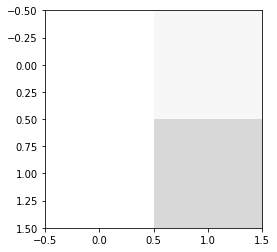

In [134]:
imshow(Images_Negative2[821])

In [135]:
# Standardizing the image arrays

for i in range(len(X_Positive2)):
    X_Positive2[i] = X_Positive2[i]/255.0
    
for i in range(len(X_Negative2)):
    X_Negative2[i] = X_Negative2[i]/255.0

In [136]:
# Creating X and Y by stacking the positive and negative image arrays

X2 = np.vstack((X_Positive2, X_Negative2))
Y2 = np.hstack((Y_Positive, Y_Negative))

In [137]:
# Splitting X and Y into train and test sets

X_Train2, X_Test2, Y_Train2, Y_Test2 = train_test_split(X2, Y2, test_size = 0.1, random_state = 42)

### Using a Standard Convolutional Neural Network with 2 x 2 x 3 Images

In [138]:
# Creating the model

def StandardModel2(input_shape = (2, 2, 3), classes = 1):
    """
    Stage-wise implementation of the architecture of the standard convolutional neural network for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK (no skip connection) -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((7, 7))(X_input)
    
    # Seven layers of zero padding are placed around the input
    # The amount of padding is increased to compensate for the smaller input array
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # For Stage 1, a convolutional layer is applied to the input with filter size 64 x 64 and a stride of 2
    # This is followed by batch normalization and a ReLU activation
    # Lastly, a max pooling layer is applied with filter size 3 x 3 and a stride of 2

    # Stage 2
    X = convolutional_block_standard(X, f = 3, filters = [64, 64, 256], s = 1)

    # For Stage 2, the standard convolutional block function is applied to the input with filter sizes of 64 x 64, 64 x 64, and 256 x 256
    
    ## AVGPOOL
    X = AveragePooling2D(pool_size = (2, 2))(X)

    # An average pooling filter is applied to the input with a filter size 2 x 2
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # The final section involves flattening the input into a vector
    # The vector is then passed through a dense neural network layer with sigmoid activation
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [139]:
Standard_Model2 = StandardModel2(input_shape = (2, 2, 3), classes = 1)

# Compile the model
Standard_Model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
Standard_Model2.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 2, 2, 3)]         0         
_________________________________________________________________
zero_padding2d_10 (ZeroPaddi (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 5, 5, 64)          9472      
_________________________________________________________________
batch_normalization_45 (Batc (None, 5, 5, 64)          256       
_________________________________________________________________
activation_40 (Activation)   (None, 5, 5, 64)          0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 2, 2, 64)          416

In [140]:
# Training the model
Standard_History2 = Standard_Model2.fit(X_Train2, Y_Train2, epochs = 200, batch_size = 8)

Epoch 1/200
213/213 [==============================] - ETA: 1:53 - loss: 0.7186 - accuracy: 0.50 - ETA: 0s - loss: 0.7965 - accuracy: 0.4886 - ETA: 0s - loss: 0.7421 - accuracy: 0.54 - ETA: 0s - loss: 0.7030 - accuracy: 0.58 - ETA: 0s - loss: 0.6939 - accuracy: 0.59 - ETA: 0s - loss: 0.6846 - accuracy: 0.60 - ETA: 0s - loss: 0.6868 - accuracy: 0.60 - ETA: 0s - loss: 0.6828 - accuracy: 0.60 - ETA: 0s - loss: 0.6838 - accuracy: 0.60 - ETA: 0s - loss: 0.6858 - accuracy: 0.59 - ETA: 0s - loss: 0.6813 - accuracy: 0.60 - ETA: 0s - loss: 0.6818 - accuracy: 0.60 - 1s 3ms/step - loss: 0.6790 - accuracy: 0.6104
Epoch 2/200
213/213 [==============================] - ETA: 0s - loss: 0.4456 - accuracy: 0.87 - ETA: 0s - loss: 0.6524 - accuracy: 0.59 - ETA: 0s - loss: 0.6733 - accuracy: 0.56 - ETA: 0s - loss: 0.6679 - accuracy: 0.59 - ETA: 0s - loss: 0.6615 - accuracy: 0.61 - ETA: 0s - loss: 0.6534 - accuracy: 0.62 - ETA: 0s - loss: 0.6595 - accuracy: 0.61 - ETA: 0s - loss: 0.6553 - accuracy: 0.61 - 

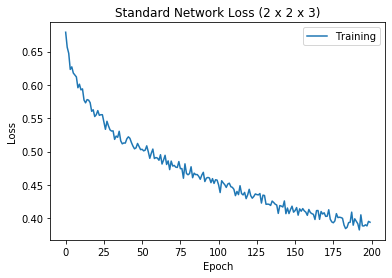

In [141]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History2.history['loss'])
plt.title('Standard Network Loss (2 x 2 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

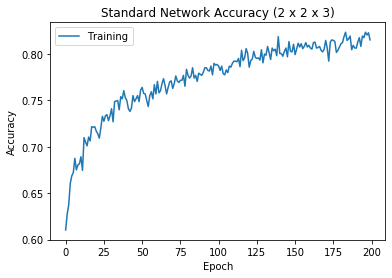

In [142]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History2.history['accuracy'])
plt.title('Standard Network Accuracy (2 x 2 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper left')
plt.show()

In [143]:
# Testing the model
Standard_Test_Loss2, Standard_Test_Accuracy2 = Standard_Model2.evaluate(X_Test2, Y_Test2)

6/6 [==============================] - ETA: 0s - loss: 0.6091 - accuracy: 0.87 - 0s 3ms/step - loss: 0.5162 - accuracy: 0.7989


In [144]:
print('Test Loss:', Standard_Test_Loss2)
print('Test Accuracy:', Standard_Test_Accuracy2)

Test Loss: 0.5162442922592163
Test Accuracy: 0.7989417910575867


### Using a Residual Network with 2 x 2 x 3 Images

In [145]:
# Creating the model

def ResNet2(input_shape = (2, 2, 3), classes = 1):
    """
    Stage-wise implementation of the architecture of the standard convolutional neural network for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK (skip connection) -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((7, 7))(X_input)
    
    # Seven layers of zero padding are placed around the input
    # The amount of padding is increased to compensate for the smaller input array
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # For Stage 1, a convolutional layer is applied to the input with filter size 64 x 64 and a stride of 2
    # This is followed by batch normalization and a ReLU activation
    # Lastly, a max pooling layer is applied with filter size 3 x 3 and a stride of 2

    # Stage 2
    X = convolutional_block_skip(X, f = 3, filters = [64, 64, 256], s = 1)

    # For Stage 2, the convolutional block function with a skip connection is applied to the input with filter sizes of 64 x 64, 64 x 64, and 256 x 256
    
    ## AVGPOOL
    X = AveragePooling2D(pool_size = (2, 2))(X)

    # An average pooling filter is applied to the input with a filter size 2 x 2
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # The final section involves flattening the input into a vector
    # The vector is then passed through a dense neural network layer with sigmoid activation
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [146]:
ResNet_Model2 = ResNet2(input_shape = (2, 2, 3), classes = 1)

# Compile the model
ResNet_Model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
print(ResNet_Model2.summary())

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 2, 2, 3)]    0                                            
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 16, 16, 3)    0           input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 5, 5, 64)     9472        zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 5, 5, 64)     256         conv2d_49[0][0]                  
___________________________________________________________________________________________

In [147]:
# Training the model
ResNet_History2 = ResNet_Model2.fit(X_Train2, Y_Train2, epochs = 200, batch_size = 8)

Epoch 1/200
213/213 [==============================] - ETA: 2:04 - loss: 0.9557 - accuracy: 0.50 - ETA: 0s - loss: 0.7592 - accuracy: 0.5893 - ETA: 0s - loss: 0.7331 - accuracy: 0.59 - ETA: 0s - loss: 0.7285 - accuracy: 0.61 - ETA: 0s - loss: 0.7331 - accuracy: 0.59 - ETA: 0s - loss: 0.7131 - accuracy: 0.60 - ETA: 0s - loss: 0.7062 - accuracy: 0.61 - ETA: 0s - loss: 0.7097 - accuracy: 0.60 - ETA: 0s - loss: 0.7067 - accuracy: 0.60 - ETA: 0s - loss: 0.7064 - accuracy: 0.60 - ETA: 0s - loss: 0.7048 - accuracy: 0.60 - ETA: 0s - loss: 0.7031 - accuracy: 0.60 - 1s 3ms/step - loss: 0.7032 - accuracy: 0.6009
Epoch 2/200
213/213 [==============================] - ETA: 0s - loss: 0.5596 - accuracy: 0.62 - ETA: 0s - loss: 0.6076 - accuracy: 0.71 - ETA: 0s - loss: 0.5887 - accuracy: 0.70 - ETA: 0s - loss: 0.6079 - accuracy: 0.67 - ETA: 0s - loss: 0.6272 - accuracy: 0.66 - ETA: 0s - loss: 0.6329 - accuracy: 0.65 - ETA: 0s - loss: 0.6474 - accuracy: 0.64 - ETA: 0s - loss: 0.6475 - accuracy: 0.63 - 

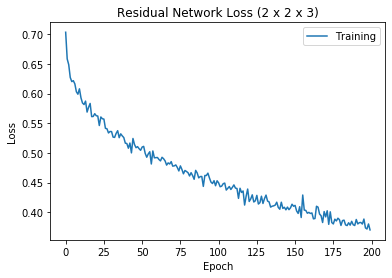

In [148]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(ResNet_History2.history['loss'])
plt.title('Residual Network Loss (2 x 2 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

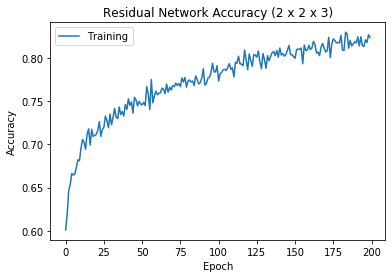

In [149]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(ResNet_History2.history['accuracy'])
plt.title('Residual Network Accuracy (2 x 2 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper left')
plt.show()

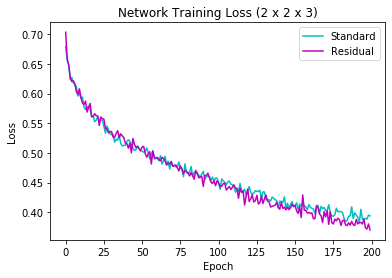

In [150]:
# Plotting the loss during training

# Information about plotting loss: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History2.history['loss'], color = 'c')
plt.plot(ResNet_History2.history['loss'], color = 'm')
plt.title('Network Training Loss (2 x 2 x 3)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Standard', 'Residual'], loc='upper right')
plt.show()

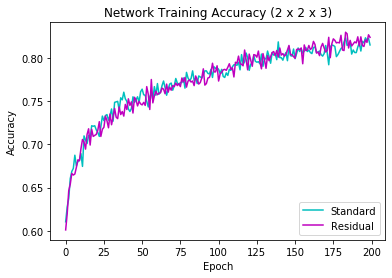

In [151]:
# Plotting the accuracy during training

# Information about plotting accuracy: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(Standard_History2.history['accuracy'], color = 'c')
plt.plot(ResNet_History2.history['accuracy'], color = 'm')
plt.title('Network Training Accuracy (2 x 2 x 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Standard', 'Residual'], loc='lower right')
plt.show()

In [152]:
# Testing the model
ResNet_Test_Loss2, ResNet_Test_Accuracy2 = ResNet_Model2.evaluate(X_Test2, Y_Test2)

6/6 [==============================] - ETA: 0s - loss: 0.7572 - accuracy: 0.87 - 0s 4ms/step - loss: 0.5607 - accuracy: 0.7831


In [153]:
print('Test Loss:', ResNet_Test_Loss2)
print('Test Accuracy:', ResNet_Test_Accuracy2)

Test Loss: 0.560748815536499
Test Accuracy: 0.7830687761306763


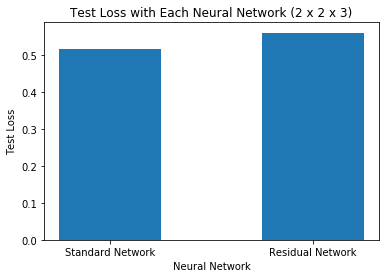

In [154]:
# Plotting the Test Loss

MethodAxis = ['Standard Network', 'Residual Network']
LossAxis2 = [Standard_Test_Loss2, ResNet_Test_Loss2]
plt.bar(MethodAxis, LossAxis2, width = 0.5)
plt.xlabel('Neural Network')
plt.ylabel('Test Loss')
plt.title('Test Loss with Each Neural Network (2 x 2 x 3)')
plt.show()

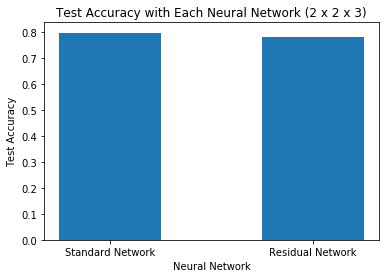

In [155]:
# Plotting the Test Accuracy

AccuracyAxis2 = [Standard_Test_Accuracy2, ResNet_Test_Accuracy2]
plt.bar(MethodAxis, AccuracyAxis2, width = 0.5)
plt.xlabel('Neural Network')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy with Each Neural Network (2 x 2 x 3)')
plt.show()

### Comparing the Test Loss and Test Accuracy of each Network using each Image Size

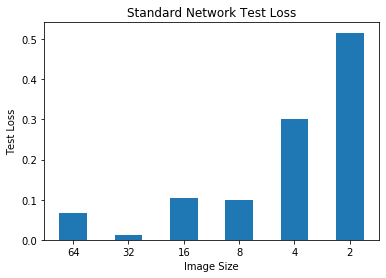

In [156]:
# Plotting the Test Loss of each Standard Convolutional Neural Network

SizeAxis = ['64', '32', '16', '8', '4', '2']
StandardLossAxisAll = [Standard_Test_Loss64, Standard_Test_Loss32, Standard_Test_Loss16, Standard_Test_Loss8, Standard_Test_Loss4, Standard_Test_Loss2]
plt.bar(SizeAxis, StandardLossAxisAll, width = 0.5)
plt.xlabel('Image Size')
plt.ylabel('Test Loss')
plt.title('Standard Network Test Loss')
plt.show()

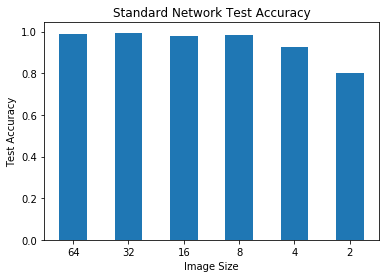

In [157]:
# Plotting the Test Accuracy of each Sequential Neural Network

StandardAccuracyAxisAll = [Standard_Test_Accuracy64, Standard_Test_Accuracy32, Standard_Test_Accuracy16, Standard_Test_Accuracy8, Standard_Test_Accuracy4, Standard_Test_Accuracy2]
plt.bar(SizeAxis, StandardAccuracyAxisAll, width = 0.5)
plt.xlabel('Image Size')
plt.ylabel('Test Accuracy')
plt.title('Standard Network Test Accuracy')
plt.show()

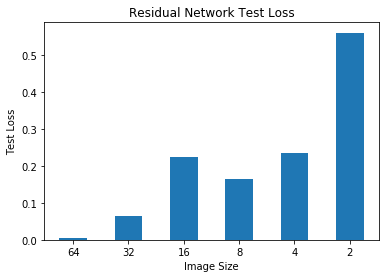

In [158]:
# Plotting the Test Loss of each Residual Network

ResNetLossAxisAll = [ResNet_Test_Loss64, ResNet_Test_Loss32, ResNet_Test_Loss16, ResNet_Test_Loss8, ResNet_Test_Loss4, ResNet_Test_Loss2]
plt.bar(SizeAxis, ResNetLossAxisAll, width = 0.5)
plt.xlabel('Image Size')
plt.ylabel('Test Loss')
plt.title('Residual Network Test Loss')
plt.show()

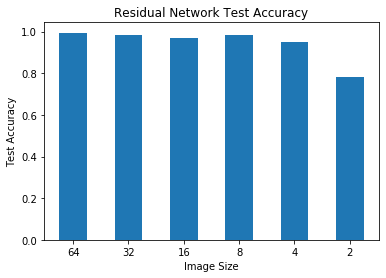

In [159]:
# Plotting the Test Accuracy of each Residual Network

ResNetAccuracyAxisAll = [ResNet_Test_Accuracy64, ResNet_Test_Accuracy32, ResNet_Test_Accuracy16, ResNet_Test_Accuracy8, ResNet_Test_Accuracy4, ResNet_Test_Accuracy2]
plt.bar(SizeAxis, ResNetAccuracyAxisAll, width = 0.5)
plt.xlabel('Image Size')
plt.ylabel('Test Accuracy')
plt.title('Residual Network Test Accuracy')
plt.show()

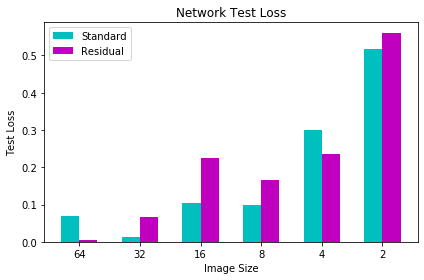

In [160]:
# Plotting the Test Loss of every Convolutional Neural Network

SizeAxisLabels = ['64', '32', '16', '8', '4', '2']
SizeAxis = np.arange(len(SizeAxisLabels))
StandardLossAxisAll = [Standard_Test_Loss64, Standard_Test_Loss32, Standard_Test_Loss16, Standard_Test_Loss8, Standard_Test_Loss4, Standard_Test_Loss2]
ResNetLossAxisAll = [ResNet_Test_Loss64, ResNet_Test_Loss32, ResNet_Test_Loss16, ResNet_Test_Loss8, ResNet_Test_Loss4, ResNet_Test_Loss2]

fig, ax = plt.subplots()
ax.bar(SizeAxis - 0.15, StandardLossAxisAll, width = 0.3, color = 'c', label = 'Standard')
ax.bar(SizeAxis + 0.15, ResNetLossAxisAll, width = 0.3, color = 'm', label = 'Residual')
ax.set_xlabel('Image Size')
ax.set_ylabel('Test Loss')
ax.set_title('Network Test Loss')
ax.set_xticks(SizeAxis)
ax.set_xticklabels(SizeAxisLabels)
ax.legend(loc = 'upper left')
fig.tight_layout()
plt.show()

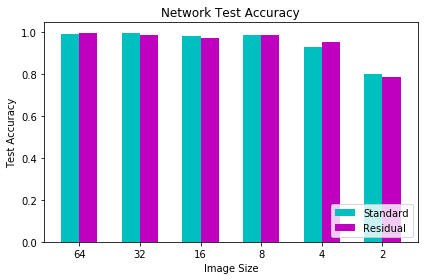

In [161]:
# Plotting the Test Accuracy of every Convolutional Neural Network

SizeAxisLabels = ['64', '32', '16', '8', '4', '2']
SizeAxis = np.arange(len(SizeAxisLabels))
StandardAccuracyAxisAll = [Standard_Test_Accuracy64, Standard_Test_Accuracy32, Standard_Test_Accuracy16, Standard_Test_Accuracy8, Standard_Test_Accuracy4, Standard_Test_Accuracy2]
ResNetAccuracyAxisAll = [ResNet_Test_Accuracy64, ResNet_Test_Accuracy32, ResNet_Test_Accuracy16, ResNet_Test_Accuracy8, ResNet_Test_Accuracy4, ResNet_Test_Accuracy2]

fig, ax = plt.subplots()
ax.bar(SizeAxis - 0.15, StandardAccuracyAxisAll, width = 0.3, color = 'c', label = 'Standard')
ax.bar(SizeAxis + 0.15, ResNetAccuracyAxisAll, width = 0.3, color = 'm', label = 'Residual')
ax.set_xlabel('Image Size')
ax.set_ylabel('Test Accuracy')
ax.set_title('Network Test Accuracy')
ax.set_xticks(SizeAxis)
ax.set_xticklabels(SizeAxisLabels)
ax.legend(loc = 'lower right')
fig.tight_layout()
plt.show()